In [11]:
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Sequential
from keras.models import load_model
from keras.models import Model
from keras.layers import Dense
from keras.layers.merge import concatenate

from matplotlib import pyplot
from os import makedirs
from numpy import dstack
from numpy import argmax
from numpy import array
from numpy import mean
from numpy import std
import numpy
from numpy import tensordot
from numpy.linalg import norm
from itertools import product
from scipy.optimize import differential_evolution

### Based Line 

Train: 0.840, Test: 0.807


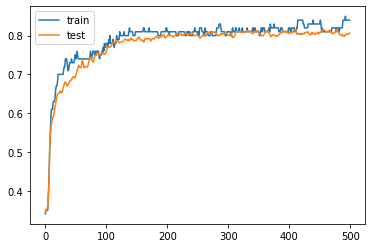

In [ ]:
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
y = to_categorical(y)

n_train = 100
trainX, testX = X[:n_train, :], X[n_train:, :]
trainy, testy = y[:n_train], y[n_train:]

model = Sequential()
model.add(Dense(25, input_dim=2, activation='relu'))
model.add(Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=500, verbose=0)
_, train_acc = model.evaluate(trainX, trainy, verbose=0)
_, test_acc = model.evaluate(testX, testy, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))

pyplot.plot(history.history['accuracy'], label='train')
pyplot.plot(history.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

### Model Averaging Assemble

In [2]:
def FitModel(X_train, y_train):
  y_train_encoded = to_categorical(y_train)

  model = Sequential()
  model.add(Dense(25, input_dim=2, activation='relu'))
  model.add(Dense(3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  model.fit(X_train, y_train_encoded, epochs=500, verbose=0)

  return model

In [3]:
def EnsemblePredictions(models, X_test):
  prediction = [model.predict(X_test) for model in models]
  prediction = array(prediction)
  summed = numpy.sum(prediction, axis=0)
  result = argmax(summed, axis=1)

  return result

In [4]:
def EvaluateModels(models, n_members, X_test, y_test):
  subset = models[:n_members]
  prediction = EnsemblePredictions(subset, X_test)
  accuracy = accuracy_score(y_test, prediction)

  return accuracy

> 1: Single: 0.8169999718666077, Ensemble: 0.817
> 2: Single: 0.8119999766349792, Ensemble: 0.819
> 3: Single: 0.8140000104904175, Ensemble: 0.819
> 4: Single: 0.8080000281333923, Ensemble: 0.817
> 5: Single: 0.8149999976158142, Ensemble: 0.815
> 6: Single: 0.8080000281333923, Ensemble: 0.819
> 7: Single: 0.8029999732971191, Ensemble: 0.817
> 8: Single: 0.8130000233650208, Ensemble: 0.817
> 9: Single: 0.8069999814033508, Ensemble: 0.818
> 10: Single: 0.8059999942779541, Ensemble: 0.816
Accuracy 0.810 (0.004)


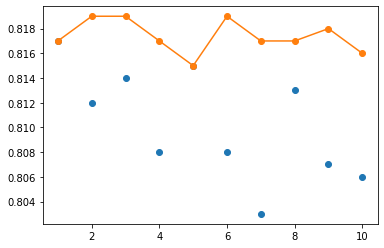

In [ ]:
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
n_train = 100
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

n_members = 10
models = [FitModel(X_train, y_train) for _ in range(n_members)]
single_scores = []
ensemble_scores = []

for i in range(1, len(models) + 1):
  ensemble_score = EvaluateModels(models, i, X_test, y_test)
  y_test_encoded = to_categorical(y_test)
  _, single_score = models[i - 1].evaluate(X_test, y_test_encoded, verbose=0)
  ensemble_scores.append(ensemble_score)
  single_scores.append(single_score)
  print(f'> {i}: Single: {single_score}, Ensemble: {ensemble_score}')

print('Accuracy %.3f (%.3f)' % (mean(single_scores), std(single_scores)))
x_axis = [i for i in range(1, len(models) + 1)]
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.show()

### Grid Search Weighted Average Ensemble

In [5]:
def EnsemblePredictions(models, weights, X_test):
  prediction = [model.predict(X_test) for model in models]
  prediction = array(prediction)
  summed = tensordot(prediction, weights, axes=((0),(0)))
  result = argmax(summed, axis=1)

  return result

In [13]:
def EvaluateModels(models, weights, X_test, y_test):
  prediction = EnsemblePredictions(models, weights, X_test)
  accuracy = accuracy_score(y_test, prediction)

  return accuracy

In [7]:
def Normalized(weights):
  result = norm(weights, 1)
  return weights if result == 0.0 else (weights / result)

In [8]:
def GridSearch(models, X_test, y_test):
  weight = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
  best_score, best_weights = 0.0, None

  for weights in product(weight, repeat=len(models)):
    if len(set(weights)) == 1:
      continue
    
    weights = Normalized(weights)
    score = EvaluateModels(models, weights, X_test, y_test)

    if score > best_score:
      best_score, best_weights = score, weights
      print(f'Best Score: {best_score}, Best Weights: {best_weights}')

  return list(best_weights)

In [ ]:
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
n_train = 100
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

n_members = 5
models = [FitModel(X_train, y_train) for _ in range(n_members)]
y_test_encoded = to_categorical(y_test)
single_scores = []
ensemble_scores = []

for i in range(n_members):
  _, test_accuracy = models[i].evaluate(X_test, y_test_encoded, verbose=0)
  print(f'Model {i + 1}: {test_accuracy}')

weights = [1.0 / n_members for _ in range(n_members)]
score = EvaluateModels(models, weights, X_test, y_test)
print(f'Equal Weights Score: {score}')

weights = GridSearch(models, X_test, y_test)
score = EvaluateModels(models, weights, X_test, y_test)
print(f'Grid Search Weights: {weights}, Score: {score}')

Model 1: 0.8109999895095825
Model 2: 0.8130000233650208
Model 3: 0.8220000267028809
Model 4: 0.8069999814033508
Model 5: 0.8069999814033508
Equal Weights Score: 0.813
Best Score: 0.807, Best Weights: [0. 0. 0. 0. 1.]
Best Score: 0.809, Best Weights: [0.  0.  0.  0.5 0.5]
Best Score: 0.811, Best Weights: [0.         0.         0.         0.33333333 0.66666667]
Best Score: 0.822, Best Weights: [0. 0. 1. 0. 0.]


### Alternative Weighted Average Ensemble

In [14]:
def LossFunction(weights, models, X_test, y_test):
  normalized = Normalized(weights)
  error_rate = 1.0 - EvaluateModels(models, normalized, X_test, y_test)

  return error_rate

In [15]:
X, y = make_blobs(n_samples=1100, centers=3, n_features=2, cluster_std=2, random_state=2)
n_train = 100
X_train, X_test = X[:n_train, :], X[n_train:, :]
y_train, y_test = y[:n_train], y[n_train:]

n_members = 5
models = [FitModel(X_train, y_train) for _ in range(n_members)]
y_test_encoded = to_categorical(y_test)
single_scores = []
ensemble_scores = []

for i in range(n_members):
  _, test_accuracy = models[i].evaluate(X_test, y_test_encoded, verbose=0)
  print(f'Model {i + 1}: {test_accuracy}')

weights = [1.0 / n_members for _ in range(n_members)]
score = EvaluateModels(models, weights, X_test, y_test)
print(f'Equal Weights Score: {score}')

bound_w = [(0.0, 1.0)  for _ in range(n_members)]
search_arg = (models, X_test, y_test)
result = differential_evolution(LossFunction, bound_w, search_arg, maxiter=1000, tol=1e-7)
weights = Normalized(result['x'])
print(f'Optimized Weights: {weights}')

score = EvaluateModels(models, weights, X_test, y_test)
print(f'Optimized Weights Score: {weights}, Score: {score}')

Model 1: 0.8199999928474426
Model 2: 0.8029999732971191
Model 3: 0.8069999814033508
Model 4: 0.8090000152587891
Model 5: 0.8059999942779541
Equal Weights Score: 0.809
Optimized Weights: [0.28752185 0.01900983 0.33623126 0.02853035 0.3287067 ]
Optimized Weights Score: [0.28752185 0.01900983 0.33623126 0.02853035 0.3287067 ], Score: 0.815
